In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
hw_data = "/content/drive/MyDrive/HW_data.csv"

In [3]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df = pd.read_csv(hw_data)

In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.rename(columns = {'offer': 'treatment', 'conversion':'target'}, inplace=True)

In [6]:
btn = {'No Offer': 0, 'Buy One Get One': 1, 'Discount':1}
df['treatment'] = df['treatment'].replace(btn)

In [7]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [8]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [9]:
df = encode_and_bind(df, 'zip_code')
df = encode_and_bind(df, 'channel')
df.tail(10)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
63990,6,80.02,0,1,0,0,0,0,1,0,0,1,0
63991,1,306.10,1,0,1,1,0,0,1,0,0,1,0
63992,1,519.69,1,1,1,1,0,0,0,1,0,1,0
63993,4,374.07,0,1,0,1,0,0,1,0,0,1,0
63994,7,86.46,0,1,0,1,0,0,0,1,0,0,1
63995,10,105.54,1,0,0,1,0,0,0,1,0,0,1
63996,5,38.91,0,1,1,1,0,0,0,1,0,1,0
63997,6,29.99,1,0,1,1,0,0,0,1,0,1,0
63998,1,552.94,1,0,1,1,0,0,1,0,1,0,0
63999,1,472.82,0,1,0,1,0,0,1,0,0,0,1


In [13]:
df.loc[df['channel_Multichannel']==1, 'channel_Phone'] = 1
df.loc[df['channel_Multichannel']==1, 'channel_Web'] = 1
df = df.drop(columns='channel_Multichannel')

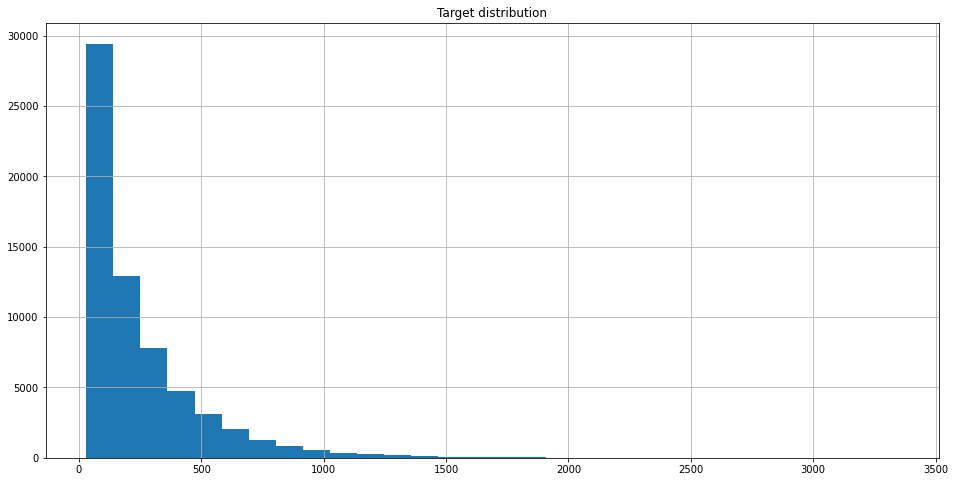

In [14]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 8))

df['history'].hist(bins=30)

plt.title('Target distribution')
plt.show()

In [15]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=42)

In [16]:
indices_valid

Int64Index([16186, 51595,  7908,  2651, 48302, 45573, 32536, 13750, 28832,
             5805,
            ...
            55875, 29764, 35993,  2045, 62581, 58977, 23578, 19299, 26447,
            37449],
           dtype='int64', length=13440)

In [17]:
X_train = df.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']
X_train = X_train.drop(columns='target')

In [18]:
X_val = df.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']
X_val = X_val.drop(columns='target')

X_train_full = df.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']
X_train_full = X_train_full.drop(columns='target')

cat_features = ['is_referral','used_bogo','used_discount']

X_test = df.loc[indices_test, :]
X_test = X_test.drop(columns='target')
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

Заведем переменные

In [19]:
!pip install scikit-uplift==0.2.0

In [20]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 43 kB/s 


uplift@20%: 0.0792


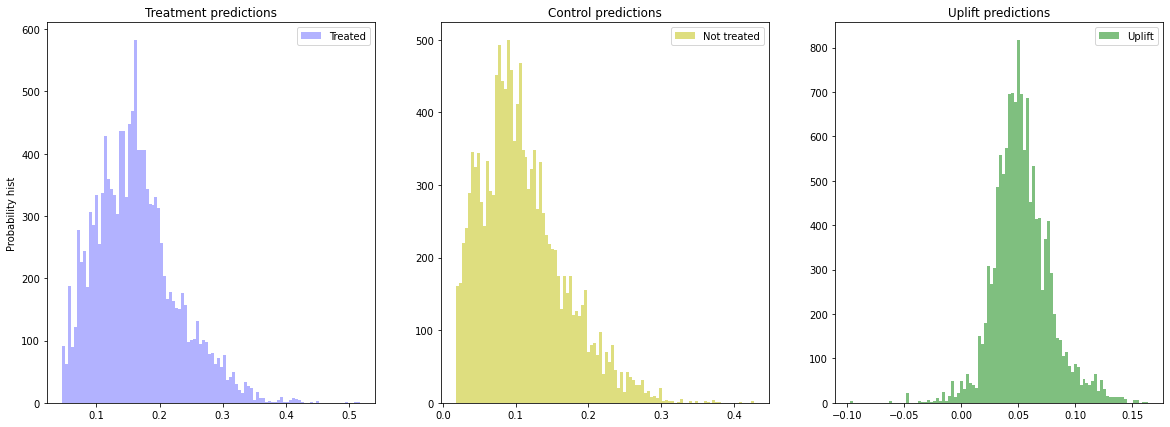

In [21]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [22]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,18.622365
1,is_referral,16.724716
2,history,15.798702
3,treatment,14.490909
4,used_bogo,8.494578
5,used_discount,8.384367
6,channel_Phone,5.106151
7,zip_code_Rural,4.733272
8,channel_Web,3.739594
9,zip_code_Urban,2.117204


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [23]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

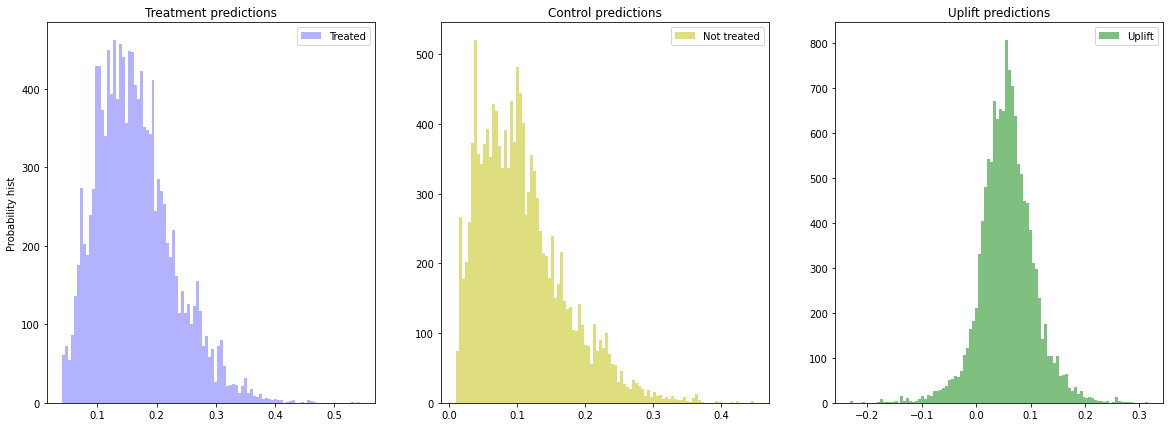

In [24]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [25]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@20%,uplift@10%
1,ClassTransformation,0.209996,0.253662
2,TwoModels,0.067523,0.083529
0,SoloModel,0.079240,0.078995
